### Experiment 1

Test model on Dataset 1 to establish a baseline (with relabeling)


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from catboost import Pool, CatBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression

import json
import sys
sys.path.append('C:\\Users\\rooty\\UWEC\\Research\\CyberBullyingML\\venv\\cyberbullying-ml\\src')
from utils.results import append_results_to_json, create_results_file
from utils.data import get_OOV_feats

from pathlib import Path
import random

In [3]:
# CONSTANTS
RANDOM_SEED = 115
DATA_PATH = Path('C:\\Users\\rooty\\UWEC\\Research\\CyberBullyingML\\venv\\cyberbullying-ml\\data\\en_only')
EXPERIMENTS_PATH = Path('C:\\Users\\rooty\\UWEC\\Research\\CyberBullyingML\\venv\\cyberbullying-ml\\experiments')
RESULT_PATH = Path('C:\\Users\\rooty\\UWEC\\Research\\CyberBullyingML\\venv\\cyberbullying-ml\\experiments\\results\\exp1')

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [4]:
create_results_file(RESULT_PATH / 'exp1.json')

Results file already exists. Not creating new one


In [4]:
df = pd.read_csv( DATA_PATH / '48000_cyberbullying_tweets_basic_clean.csv')

In [5]:
df.dropna(axis=0, inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [6]:
df['label'].value_counts()

label
religion     7942
age          7910
gender       7396
ethnicity    7319
other        6731
notcb        6377
Name: count, dtype: int64

In [7]:
# relabel the data so that all cyberbullying data is a single class
# relabel the data so that all cyberbullying data is a single class

# {'age':0, 'gender':1, 'other':2, 'religion':3, 'ethnicity':4, 'notcb':5}

# Assuming 'label' column contains the labels and 'notcb' is the non-cyberbullying class
cyberbullying_classes = ['age', 'gender', 'other', 'religion', 'ethnicity']

# Relabel the data
df['label'] = df['label'].apply(lambda x: 1 if x in cyberbullying_classes else 0)

# Verify the relabeling
print(df['label'].value_counts())

label
1    37298
0     6377
Name: count, dtype: int64


In [8]:
# Split the data

x_train, x_test, y_train, y_test = train_test_split(df['tweet'], df['label'], test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

In [10]:
# Additional split for val
x_train, x_val, y_train, y_val = train_test_split(df['tweet'], df['label'], test_size=0.125, shuffle=True, random_state=RANDOM_SEED) # use 10% of the original dataset for validation

In [11]:
# vectorize the data
cv = CountVectorizer(max_df=0.5)
x_train = cv.fit_transform(x_train)
x_val = cv.transform(x_val)
x_test = cv.transform(x_test)

In [15]:
hyps = {
    'max_depth': 12,
    'booster': 'gbtree',
    'learning_rate': 0.1,
    'n_estimators': 50,
    'colsample_bytree': 0.8,
    'reg_alpha': 2
}

In [12]:
m = xgb.XGBClassifier(
    early_stopping_rounds=10,
    random_state=RANDOM_SEED,
)

fit_params={'eval_set': [(x_val, y_val)]}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
results = cross_val_score(m, x_train, y_train, scoring='roc_auc', fit_params=fit_params, verbose=3, cv=skf)

c:\Users\rooty\UWEC\Research\CyberBullyingML\venv\lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.37819
[1]	validation_0-logloss:0.35132
[2]	validation_0-logloss:0.33650
[3]	validation_0-logloss:0.32083
[4]	validation_0-logloss:0.31013
[5]	validation_0-logloss:0.30396
[6]	validation_0-logloss:0.29704
[7]	validation_0-logloss:0.28991
[8]	validation_0-logloss:0.28625
[9]	validation_0-logloss:0.28196
[10]	validation_0-logloss:0.27871
[11]	validation_0-logloss:0.27601
[12]	validation_0-logloss:0.27301
[13]	validation_0-logloss:0.27079
[14]	validation_0-logloss:0.26847
[15]	validation_0-logloss:0.26668
[16]	validation_0-logloss:0.26463
[17]	validation_0-logloss:0.26317
[18]	validation_0-logloss:0.26178
[19]	validation_0-logloss:0.26014
[20]	validation_0-logloss:0.25900
[21]	validation_0-logloss:0.25751
[22]	validation_0-logloss:0.25671
[23]	validation_0-logloss:0.25533
[24]	validation_0-logloss:0.25459
[25]	validation_0-logloss:0.25378
[26]	validation_0-logloss:0.25312
[27]	validation_0-logloss:0.25224
[28]	validation_0-logloss:0.25133
[29]	validation_0-loglos

In [ ]:
preds = m.predict(x_test)
print(report:=classification_report(y_test, preds))

In [40]:
# XGBClassifer Tests

# split dataset 3 ways 80/20, 70/30, 60/40

TEST_SIZES = [0.2,0.3,0.4]

for size in TEST_SIZES:

    for vect in [CountVectorizer(), CountVectorizer(ngram_range=(1,2)), TfidfVectorizer(), TfidfVectorizer(ngram_range=(1,2))]:

        x_train, x_test, y_train, y_test = train_test_split(df['tweet'], df['label'], test_size=size, shuffle=True, random_state=RANDOM_SEED)

        x_train = vect.fit_transform(x_train)
        # calculate the number of OOV features
        vect2 = CountVectorizer()
        vect2.fit(x_test)
        feats_train = vect.get_feature_names_out()
        feats_test = vect2.get_feature_names_out()
        oov_feats = np.setdiff1d(feats_test, feats_train)

        x_test = vect.transform(x_test)
        
        ratio = (y_train == 0).sum() / (y_train == 1).sum() # the ratio of neg to pos (i.e. noncb to cb)

        m = xgb.XGBClassifier(random_state=RANDOM_SEED, scale_pos_weight=ratio)
        m.fit(x_train, y_train)
        y_pred = m.predict(x_test)
        result = classification_report(y_test, y_pred, output_dict=True)
        result['test_size'] = size
        result['num_OOV_feats'] = len(oov_feats)
        result['neg_to_pos_ratio'] = ratio
        result['model_name'] = 'XGBClassifier'
        result['model_params'] = {k: str(v) if isinstance(v, type) else v for k, v in m.get_params().items()}
        result['vectorizer'] = vect.__class__.__name__
        result['vectorizer_params'] = {k: str(v) if isinstance(v, type) else v for k, v in vect.get_params().items()}
        append_results_to_json(result, RESULT_PATH / 'exp1.json')

In [46]:
# CatBoostClassifier Tests

# split dataset 3 ways 80/20, 70/30, 60/40

TEST_SIZES = [0.2,0.3,0.4]

for size in TEST_SIZES:

    for vect in [CountVectorizer(), CountVectorizer(ngram_range=(1,2)), TfidfVectorizer(), TfidfVectorizer(ngram_range=(1,2))]:

        x_train, x_test, y_train, y_test = train_test_split(df['tweet'], df['label'], test_size=size, shuffle=True, random_state=RANDOM_SEED)

        x_train = vect.fit_transform(x_train)
        # calculate the number of OOV features
        vect2 = CountVectorizer()
        vect2.fit(x_test)
        feats_train = vect.get_feature_names_out()
        feats_test = vect2.get_feature_names_out()
        oov_feats = np.setdiff1d(feats_test, feats_train)

        x_test = vect.transform(x_test)

        ratio = (y_train == 0).sum() / (y_train == 1).sum() # the ratio of neg to pos (i.e. noncb to cb)

        train_pool = Pool(x_train, y_train)
        test_pool = Pool(x_test, y_test)

        m = CatBoostClassifier(random_state=RANDOM_SEED, class_weights=[1,ratio])
        m.fit(train_pool)
        y_pred = m.predict(test_pool)
        result = classification_report(y_test, y_pred, output_dict=True)
        result['test_size'] = size
        result['num_OOV_feats'] = len(oov_feats)
        result['model_name'] = 'CatBoostClassifier'
        result['model_params'] = {k: str(v) if isinstance(v, type) else v for k, v in m.get_all_params().items()}
        result['vectorizer'] = vect.__class__.__name__
        result['vectorizer_params'] = {k: str(v) if isinstance(v, type) else v for k, v in vect.get_params().items()}
        append_results_to_json(result, RESULT_PATH / 'exp1.json')

Learning rate set to 0.046982
0:	learn: 0.6717098	total: 92.4ms	remaining: 1m 32s
1:	learn: 0.6528633	total: 182ms	remaining: 1m 30s
2:	learn: 0.6361452	total: 278ms	remaining: 1m 32s
3:	learn: 0.6214207	total: 373ms	remaining: 1m 32s
4:	learn: 0.6056920	total: 496ms	remaining: 1m 38s
5:	learn: 0.5934752	total: 594ms	remaining: 1m 38s
6:	learn: 0.5833602	total: 699ms	remaining: 1m 39s
7:	learn: 0.5738289	total: 790ms	remaining: 1m 37s
8:	learn: 0.5657452	total: 882ms	remaining: 1m 37s
9:	learn: 0.5575197	total: 982ms	remaining: 1m 37s
10:	learn: 0.5509106	total: 1.07s	remaining: 1m 36s
11:	learn: 0.5449995	total: 1.16s	remaining: 1m 35s
12:	learn: 0.5383253	total: 1.25s	remaining: 1m 35s
13:	learn: 0.5330324	total: 1.35s	remaining: 1m 34s
14:	learn: 0.5281239	total: 1.44s	remaining: 1m 34s
15:	learn: 0.5235287	total: 1.52s	remaining: 1m 33s
16:	learn: 0.5185596	total: 1.61s	remaining: 1m 33s
17:	learn: 0.5137017	total: 1.7s	remaining: 1m 32s
18:	learn: 0.5098134	total: 1.79s	remaining:

In [13]:
import json

with open(RESULT_PATH / 'exp1.json', 'r') as file:
    results = json.load(file)['results']

xgboost_recall_0 = [result['0']['recall'] for result in results if result['model_name'] == 'XGBClassifier']
xgboost_recall_1 = [result['1']['recall'] for result in results if result['model_name'] == 'XGBClassifier']
print(f'XGBClassifier Average Recall for class 0: {sum(xgboost_recall_0) / len(xgboost_recall_0)}')
print(f'XGBClassifier Average Recall for class 1: {sum(xgboost_recall_1) / len(xgboost_recall_1)}')
print()
# Calculate the average Recall for each class
xgboost_precision_0 = [result['0']['precision'] for result in results if result['model_name'] == 'XGBClassifier']
xgboost_precision_1 = [result['1']['precision'] for result in results if result['model_name'] == 'XGBClassifier']
print(f'XGBClassifier Average Precision for class 0: {sum(xgboost_precision_0) / len(xgboost_precision_0)}')
print(f'XGBClassifier Average Precision for class 1: {sum(xgboost_precision_1) / len(xgboost_precision_1)}')
print()
# Calculate average F1 score for XGBClassifier models
xgboost_f1_scores_0 = [result['0']['f1-score'] for result in results if result['model_name'] == 'XGBClassifier']
xgboost_f1_scores_1 = [result['1']['f1-score'] for result in results if result['model_name'] == 'XGBClassifier']
average_xgboost_f1_cls0 = sum(xgboost_f1_scores_0) / len(xgboost_f1_scores_0)
average_xgboost_f1_cls1 = sum(xgboost_f1_scores_1) / len(xgboost_f1_scores_1)
print(f'XGBClassifier Average F1 Score for Class 0: {average_xgboost_f1_cls0}')
print(f'XGBClassifier Average F1 Score for Class 1: {average_xgboost_f1_cls1}')

XGBClassifier Average Recall for class 0: 0.9267513482549478
XGBClassifier Average Recall for class 1: 0.7860688862645677

XGBClassifier Average Precision for class 0: 0.42110562419978415
XGBClassifier Average Precision for class 1: 0.9845916038022046

XGBClassifier Average F1 Score for Class 0: 0.5790436991816209
XGBClassifier Average F1 Score for Class 1: 0.8741913701231249


In [8]:


# Get the result with the highest precision for class 1


XGBClassifier Average Precision for class 0: 0.42110562419978415
XGBClassifier Average Precision for class 1: 0.9845916038022046
XGBClassifier Average F1 Score for Class 0: 0.5790436991816209
XGBClassifier Average F1 Score for Class 1: 0.8741913701231249


In [6]:
# get the average precision for each class from the catboost results
catboost_precision_0 = [result['0']['recall'] for result in results if result['model_name'] == 'CatBoostClassifier']
catboost_precision_1 = [result['1']['recall'] for result in results if result['model_name'] == 'CatBoostClassifier']
print(f'CatBoostClassifier Average Recall for class 0: {sum(catboost_precision_0) / len(catboost_precision_0)}')
print(f'CatBoostClassifier Average Recall for class 1: {sum(catboost_precision_1) / len(catboost_precision_1)}')

# get average accuracy for CatBoostClassifier
catboost_results = [result['accuracy'] for result in results if result['model_name'] == 'CatBoostClassifier']
print(f'CatBoostClassifier Average Accuracy: {sum(catboost_results) / len(catboost_results)}')

CatBoostClassifier Average Recall for class 0: 0.9044313753325498
CatBoostClassifier Average Recall for class 1: 0.798236301908981
CatBoostClassifier Average Accuracy: 0.8134921787036481


In [25]:
report = {            
    "0": {
                "precision": 0.30916699104710005,
                "recall": 0.9796484736355227,
                "f1-score": 0.4700051778977735,
                "support": 3243.0
            },
    "1": {
                "precision": 0.9936799770180983,
                "recall": 0.5937857633325704,
                "f1-score": 0.7433647336939002,
                "support": 17476.0
            },
            "accuracy": 0.6541821516482456,
            "macro avg": {
                "precision": 0.6514234840325992,
                "recall": 0.7867171184840465,
                "f1-score": 0.6066849557958369,
                "support": 20719.0
            },
            "weighted avg": {
                "precision": 0.8865379521373634,
                "recall": 0.6541821516482456,
                "f1-score": 0.7005776764301888,
                "support": 20719.0
            }}

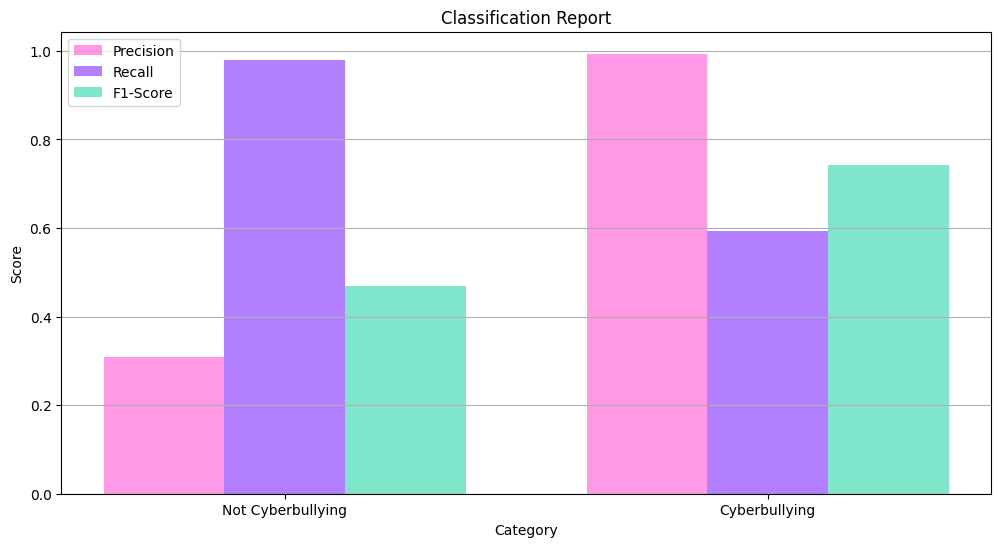

In [29]:

import matplotlib.pyplot as plt
# Generate the classification report

# Plotting the classification report
fig, ax = plt.subplots(figsize=(12, 6))

# Categories for the classification
categories = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'

# Extracting precision, recall, and f1-score
precision = [report[category]['precision'] for category in categories]
recall = [report[category]['recall'] for category in categories]
f1_score = [report[category]['f1-score'] for category in categories]

# Setting the positions and width for the bars
pos = list(range(len(categories)))
width = 0.25 

# Plotting each metric
plt.bar(pos, precision, width, alpha=0.5, color='#ff33cc', label='Precision')
plt.bar([p + width for p in pos], recall, width, alpha=0.5, color='#6600ff', label='Recall')
plt.bar([p + width*2 for p in pos], f1_score, width, alpha=0.5, color='#00cc99', label='F1-Score')

# Adding the aesthetics
plt.xlabel('Category')
plt.ylabel('Score')
plt.title('Classification Report')
plt.xticks([p + width for p in pos], 
   ['Not Cyberbullying',
    'Cyberbullying'])

# Adding the legend and showing the plot
plt.legend(['Precision', 'Recall', 'F1-Score'], loc='upper left')
plt.grid(axis='y')
plt.show()